In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.callback import Callback
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.gauss import GaussianMutation
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.problems import get_problem
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

In [7]:
# --- 1. 問題の定義 ---
# deapでの toolbox.register("evaluate", benchmarks.ackley) に相当します。
# pymooでは、多くのベンチマーク問題が用意されており、簡単に呼び出せます。
# Ackley関数の問題を取得 (次元数 n_var=2)
class CustomAckley(Problem):
    def __init__(self):
        # 変数(次元)の数と、下限(xl)・上限(xu)を定義
        super().__init__(n_var=2,
                         xl=np.array([-500.0, -500.0]),
                         xu=np.array([500.0, 500.0]))

    def _evaluate(self, x, out, *args, **kwargs):
        # Ackley関数の標準的なパラメータ
        a, b, c = 20, 0.2, 2 * np.pi
        n = self.n_var

        # numpyを使ってベクトル化された計算を実行
        term1 = -a * np.exp(-b * np.sqrt((1/n) * np.sum(x**2, axis=1)))
        term2 = -np.exp((1/n) * np.sum(np.cos(c * x), axis=1))
        
        f = term1 + term2 + a + np.exp(1)
        
        out["F"] = f

problem = get_problem("ackley", n_var=2)
#problem = CustomAckley()


# --- 2. アルゴリズムの設定 ---
# deapでのToolbox設定 (交叉、突然変異、選択) に相当します。

# pymoo公式ドキュメントで推奨されているバイナリトーナメント選択の関数
def binary_tournament(pop, P, **kwargs):
    # P: トーナメントの組み合わせを示すNumpy配列 (n_tournaments, n_competitors)
    n_tournaments, n_competitors = P.shape

    # この関数は2個体によるトーナメント（バイナリトーナメント）専用
    if n_competitors != 2:
        raise ValueError("このトーナメント関数は2個体選択(pressure=2)専用です。")

    # トーナメントの勝者を格納する配列
    S = np.full(n_tournaments, -1, dtype=int)

    # 各トーナメントを実行
    for i in range(n_tournaments):
        a, b = P[i]

        # 個体aの適応度が個体bより小さい（優れている）場合
        if pop[a].F < pop[b].F:
            S[i] = a
        # それ以外の場合は個体bを選択
        else:
            S[i] = b

    return S


algorithm = GA(
    pop_size=1000,
    sampling=FloatRandomSampling(),
    # 選択: 上で定義した関数を用いたトーナメント選択
    # pressure=2で2個体によるトーナメントを指定
    selection=TournamentSelection(func_comp=binary_tournament, pressure=2),
    # 交叉: Simulated Binary Crossover (deapの cxBlend の代替として一般的)
    # 交叉確率を deap の CX_PB=0.5 と同様に設定
    crossover=SBX(prob=0.5, eta=15),
    # 突然変異: ガウス突然変異 (deapの mutGaussian と同様)
    # 突然変異確率を deap の MUT_PB=0.2 と同様に設定
    mutation=GaussianMutation(prob=0.2, sigma=5),
    eliminate_duplicates=True
)

# --- 3. 終了条件の設定 ---
# deapでの N_GEN=100 に相当します。
# 100世代で計算を終了するように設定
termination = ("n_gen", 100)


# --- 4. GAの実行 ---
# プログレスバー表示とデータ収集を兼ねるカスタムCallbackクラス
class CustomCallback(Callback):
    def __init__(self, n_gen):
        super().__init__()
        # tqdmプログレスバーを初期化
        self.pbar = tqdm(total=n_gen, desc="Evolving")
        # 各世代の統計データを格納するための辞書を初期化
        self.data = {
            "avg": [],
            "min": [],
            "std": []
        }

    def notify(self, algorithm):
        # 現在の世代の集団の適応度を取得
        pop_f = algorithm.pop.get("F")
        
        # 統計データを記録
        self.data["avg"].append(np.mean(pop_f))
        self.data["min"].append(np.min(pop_f))
        self.data["std"].append(np.std(pop_f))

        # プログレスバーを1ステップ進める
        self.pbar.update(1)

    def __del__(self):
        # 実行終了時にプログレスバーを閉じる
        self.pbar.close()

In [8]:
res = minimize(problem,
               algorithm,
               termination,
               seed=42,
               callback=CustomCallback(termination[1]),
               verbose=False)



Evolving: 100%|██████████| 100/100 [1:22:43<00:00, 49.64s/it]



-- End of evolution --
individual: [-3.17180057e-16  1.71936528e-15]
fitness: 3.9968028886505635e-15


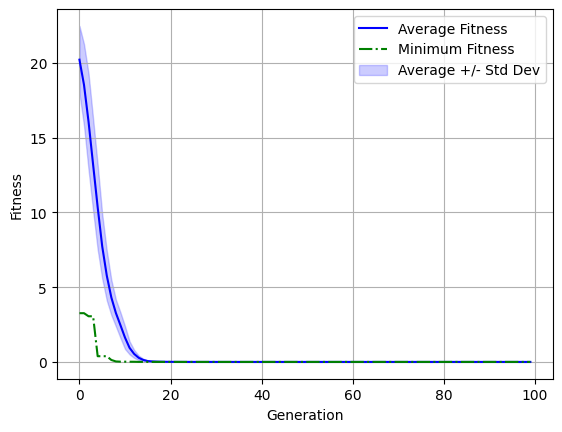

In [9]:
# --- 5. 結果の表示 ---
# deapでの hof[0] や hof[0].fitness.values に相当します。
print("\n-- End of evolution --")
print(f"individual: {res.X}")
print(f"fitness: {res.F[0]}")

# --- 6. グラフの描画 ---
# Callbackオブジェクトから統計データを直接取得してグラフを作成します。
callback_data = res.algorithm.callback.data
avg_list = np.array(callback_data["avg"])
min_list = np.array(callback_data["min"])
std_list = np.array(callback_data["std"])
n_gen = len(min_list)

gen = np.arange(n_gen)
#fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
fig, ax = plt.subplots()

# mean with solid line
line1 = ax.plot(gen, avg_list, "b-", label="Average Fitness")

# min with dashed line
line2 = ax.plot(gen, min_list, "g-.", label="Minimum Fitness")

ax.set_xlabel("Generation")
ax.set_ylabel("Fitness")

# 平均 +/- 標準偏差の範囲を塗りつぶしで表示
std_upper = avg_list + std_list
std_lower = avg_list - std_list
ax.fill_between(gen, std_lower, std_upper,
                 color='b', alpha=0.2, label="Average +/- Std Dev")

ax.legend(loc="upper right")
plt.grid(True)
plt.show()